## Mount drive & imports

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
%cd 'drive/My Drive/MIR'

import pandas as pd
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
from numpy import set_printoptions
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

Mounted at /content/drive/
/content/drive/My Drive/MIR


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Features

Load .csv files

In [2]:
#train_file = 'smile-features/4Q-train-features.csv' 
#test_file = 'smile-features/4Q-test-features.csv'
#train_file = 'smile-features/CH-train-features.csv' 
#test_file = 'smile-features/CH-test-features.csv'
train_file = 'smile-features/TR-train-features.csv' 
test_file = 'smile-features/TR-test-features.csv'    

train_data =  pd.read_csv(train_file, sep=',')
test_data =  pd.read_csv(test_file, sep=',')

train_data = train_data.drop("frameTime", axis=1)
test_data = test_data.drop("frameTime", axis=1)

print("Data is null:")
print(train_data.isnull().sum().sum())#sums a matrix of True/False values obtained by checking if each value is Nan
print(test_data.isnull().sum().sum())

Data is null:
0
0


Normalize features

In [3]:
train_data_modif = train_data.copy()
test_data_modif = test_data.copy()

min_max_scaler = preprocessing.MinMaxScaler()
train_data_modif.iloc[:,:260] = min_max_scaler.fit_transform(train_data.iloc[:,:260].values)
test_data_modif.iloc[:,:260] = min_max_scaler.fit_transform(test_data.iloc[:,:260].values)

Re-balance train set

In [4]:
train_data_modif.emotion.value_counts()

q4    328
q3    328
q1    328
q2    296
Name: emotion, dtype: int64

In [5]:
# Balancing data   ---> adapt this to the numbers above
data_modif = train_data_modif
min_number = data_modif.emotion.value_counts()['q2']
q2_data = data_modif[data_modif.emotion == 'q2'].sample(n = min_number, random_state = 42)
q1_data = data_modif[data_modif.emotion == 'q1'].sample(n = min_number, random_state = 42)
q3_data = data_modif[data_modif.emotion == 'q3'].sample(n = min_number, random_state = 42)
q4_data = data_modif[data_modif.emotion == 'q4'].sample(n = min_number, random_state = 42)

#Merging after downsampling
train_data_modif = pd.concat([q1_data, q2_data, q3_data, q4_data])
#Checking the balance again
train_data_modif.emotion.value_counts()

q4    296
q2    296
q3    296
q1    296
Name: emotion, dtype: int64

Feature selection

In [6]:
# Preparing data arrays for features and labels
#input values put in a matrix, there are 260 features
X_train = train_data_modif.iloc[:,:260].values 
X_test = test_data_modif.iloc[:,:260].values 
#Creating output values
train_data_modif.emotion = pd.Categorical(train_data_modif.emotion)#convert to categorical data
test_data_modif.emotion = pd.Categorical(test_data_modif.emotion)#convert to categorical data
y_train = np.array(train_data_modif.emotion.cat.codes) #create label encoded outputs
y_test = np.array(test_data_modif.emotion.cat.codes) #create label encoded outputs

# Feature selection
z = SelectKBest(chi2, k=50)
fit = z.fit(X_train, y_train)
# summarize scores
set_printoptions(precision=3)
ten = fit.scores_.argsort()[-10:][::-1] # 10 best features selected 

X_train = fit.transform(X_train)
X_test = fit.transform(X_test)   # only consider selected features from the training set
print('X_train shape is ', X_train.shape)
print('X_test shape is ', X_test.shape, '\n')

print('Top 10 selected features: ')
for i in ten:
    print(train_data_modif.keys()[i])

X_train shape is  (1184, 50)
X_test shape is  (320, 50) 

Top 10 selected features: 
logHNR_sma_stddev
pcm_fftMag_spectralCentroid_sma_amean
pcm_fftMag_spectralRollOff75.0_sma_amean
pcm_fftMag_spectralRollOff90.0_sma_amean
pcm_fftMag_spectralRollOff50.0_sma_de_stddev
pcm_fftMag_spectralVariance_sma_amean
pcm_zcr_sma_amean
pcm_fftMag_psySharpness_sma_amean
audspec_lengthL1norm_sma_de_stddev
pcm_fftMag_spectralRollOff50.0_sma_amean


## Machine Learning

Comparison of classifiers

In [7]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma = 1 / (X_train.shape[-1] * X_train.var())),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB(),
    RandomForestClassifier(max_depth=15, random_state=0)]

names = ["KNN", "Linear SVM", "RBF SVM", "Gaussian Process","Neural Net", "Naive Bayes", "Random Forest"]

#Creating empty list of scores for each classifier, we will append test results to these lists 
scores = {}
for name in names:
    scores[name] = []

#Let's run 10 random experiments, collect scores for each classifier 
num_tests = 10
for iteration_number in range(num_tests):
    x_train_val, x_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size = 1/num_tests, random_state = iteration_number)
    #normalisation of the data (learned from training data, applied to test data)
    scaler = StandardScaler().fit(x_train_val)
    norm_x_train = scaler.transform(x_train_val)
    norm_x_val = scaler.transform(x_val)
    
    # test over each classifier
    for name, clf in zip(names, classifiers):
        clf.fit(norm_x_train, y_train_val)#train
        score = clf.score(norm_x_val, y_val)#test
        scores[name].append(score)

for name, score in scores.items():
    print("{0}: acc = {1:1.2f}, +-{2:1.2f},\tvalues: {3}".format(name, np.mean(score), np.std(score), np.around(score, decimals = 2)))

KNN: acc = 0.85, +-0.03,	values: [0.84 0.82 0.79 0.86 0.87 0.85 0.82 0.9  0.91 0.83]
Linear SVM: acc = 0.82, +-0.02,	values: [0.84 0.84 0.8  0.85 0.81 0.82 0.8  0.8  0.87 0.82]
RBF SVM: acc = 0.55, +-0.06,	values: [0.58 0.67 0.55 0.45 0.57 0.56 0.47 0.61 0.53 0.51]
Gaussian Process: acc = 0.69, +-0.17,	values: [0.88 0.45 0.63 0.85 0.63 0.86 0.82 0.45 0.47 0.83]
Neural Net: acc = 0.88, +-0.02,	values: [0.88 0.92 0.85 0.87 0.88 0.87 0.86 0.86 0.88 0.88]
Naive Bayes: acc = 0.70, +-0.03,	values: [0.67 0.7  0.67 0.76 0.66 0.69 0.73 0.7  0.76 0.71]
Random Forest: acc = 0.86, +-0.02,	values: [0.87 0.88 0.85 0.91 0.84 0.83 0.86 0.84 0.89 0.85]


Multi-layer perceptron

Number of test samples:  320
              precision    recall  f1-score   support

           0       0.72      0.75      0.73        72
           1       0.97      0.70      0.82       104
           2       0.52      0.62      0.57        72
           3       0.64      0.75      0.69        72

    accuracy                           0.71       320
   macro avg       0.71      0.71      0.70       320
weighted avg       0.74      0.71      0.71       320

Confusion matrix: 



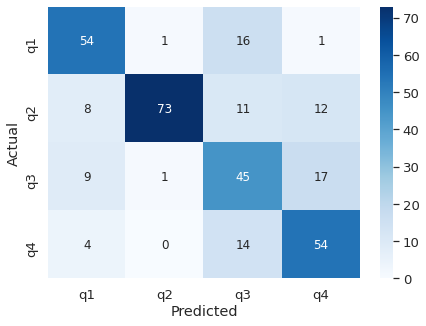

In [20]:
selected_model = MLPClassifier(alpha=1, max_iter=1000)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion matrix: \n")
classes = np.unique(test_data_modif.emotion)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");